<a href="https://colab.research.google.com/github/junaina/EmpathAI/blob/preview-warda-wip/EmpathAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded= files.upload()


Saving combined_emotion.csv to combined_emotion.csv


In [4]:
#loading dataset
import pandas as pd
df= pd.read_csv('combined_emotion.csv', sep=',', names=["text", "emotion"])
#accidental header rows
df = df[df["emotion"] != "emotion"]
df.head()

,text,emotion
1,i just feel really helpless and heavy hearted,fear
2,ive enjoyed being able to slouch about relax a...,sad
3,i gave up my internship with the dmrg and am f...,fear
4,i dont know i feel so lost,sad
5,i am a kindergarten teacher and i am thoroughl...,fear


In [5]:
  # drop the bogus header row
df= df[df["text"]!= "sentence"]
df.reset_index(drop=True,inplace=True)
df.head()

,text,emotion
0,i just feel really helpless and heavy hearted,fear
1,ive enjoyed being able to slouch about relax a...,sad
2,i gave up my internship with the dmrg and am f...,fear
3,i dont know i feel so lost,sad
4,i am a kindergarten teacher and i am thoroughl...,fear


In [16]:
import re
def clean_text(text):
  text= text.lower()
  text= re.sub(r'[^a-z0-9\s]','', text)
  return text
#applying
df["clean_text"]= df["text"].apply(clean_text)
df[["text", "clean_text"]].head()
# 4. 🔧 Downsample the overrepresented classes
min_count = df["emotion"].value_counts().min()

df = df.groupby("emotion").apply(lambda x: x.sample(min_count)).reset_index(drop=True)

<ipython-input-16-2ec35903f9d3>:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("emotion").apply(lambda x: x.sample(min_count)).reset_index(drop=True)


In [17]:
#tokenization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [18]:
tokenizer= Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(df["clean_text"])
#sequencing
sequences = tokenizer.texts_to_sequences(df["clean_text"])
#truncating any sentences over 100 words, adding pads to the end of each sequence
padded= pad_sequences(sequences, maxlen=100, padding='post', truncating='post')


In [19]:
#label encoding the emotions column to assign each emotion a numeric value
from sklearn.preprocessing import LabelEncoder
le= LabelEncoder()
df["label"]= le.fit_transform(df["emotion"])
df[["emotion", "label"]].drop_duplicates()

,emotion,label
0,anger,0
14972,fear,1
29944,joy,2
44916,love,3
59888,sad,4
74860,suprise,5


In [20]:
#building and training the neural network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
#tokenization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
model= Sequential([
    Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=128, input_length=100),
    LSTM(128,return_sequences=False),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(len(le.classes_),activation='softmax')


])

#applying
model.compile(loss= 'sparse_categorical_crossentropy',optimizer= 'adam',metrics= ['accuracy'])



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


note to self: this is how relu works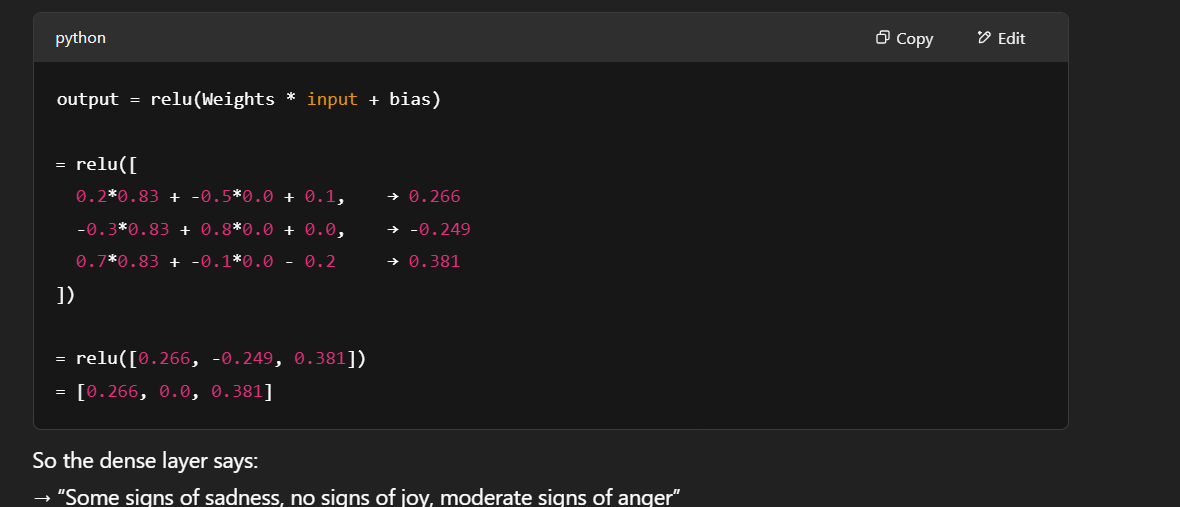

In [21]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# STEP 1: Define a better model with more power
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=128, input_length=100),
    LSTM(128, return_sequences=False),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(le.classes_), activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# STEP 2: Setup early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,  # stop if val_loss doesn't improve for 3 epochs
    restore_best_weights=True
)

# STEP 3: Split the data
X_train, X_test, y_train, y_test = train_test_split(padded, df["label"].values, test_size=0.2, random_state=42)

# STEP 4: Train the model (with early stopping)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,  # Can go higher now
    batch_size=32,
    callbacks=[early_stop]
)

# STEP 5: Save and download the trained model
model.save("emotion_model.h5")
from google.colab import files
files.download("emotion_model.h5")


Epoch 1/10
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - accuracy: 0.1712 - loss: 1.7931 - val_accuracy: 0.1578 - val_loss: 1.7932
Epoch 2/10
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 44s 13ms/step - accuracy: 0.1688 - loss: 1.7921 - val_accuracy: 0.1659 - val_loss: 1.7921
Epoch 3/10
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 37s 11ms/step - accuracy: 0.1686 - loss: 1.7922 - val_accuracy: 0.1659 - val_loss: 1.7922
Epoch 4/10
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - accuracy: 0.1649 - loss: 1.7922 - val_accuracy: 0.1578 - val_loss: 1.7923
Epoch 5/10
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - accuracy: 0.1677 - loss: 1.7920 - val_accuracy: 0.1648 - val_loss: 1.7920
Epoch 6/10
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - accuracy: 0.1702 - loss: 1.7919 - val_accuracy: 0.1578 - val_loss: 1.7924
Epoch 7/10
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - accuracy: 0.1695 - loss: 1.7927 - val_accuracy: 0.1659 - val_loss: 1.7920
Epoch 8/10
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - accuracy: 0.1637 -

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

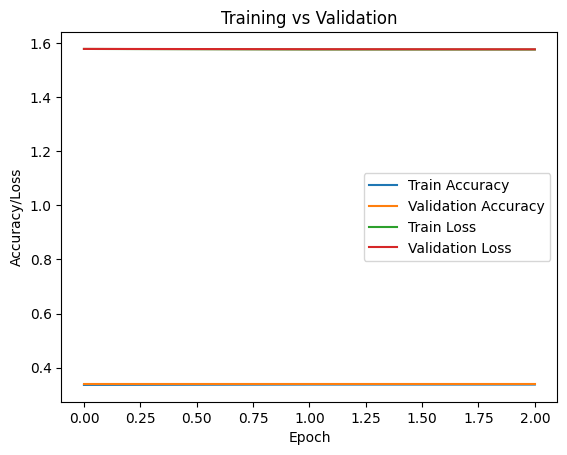

In [12]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training vs Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy/Loss')
plt.show()


In [13]:
def predict_emotion(text):
  #this function applies the model trained on predicting emotions for a  single sentences
  cleaned= clean_text(text)
  seq= tokenizer.texts_to_sequences([cleaned])
  padded_seq= pad_sequences(seq, maxlen=100, padding='post', truncating='post')


  #predicting emotion probabilities based on the model thats just been trained
  probs= model.predict(padded_seq, verbose=0)[0]
  label_index= probs.argmax()
  emotion= le.classes_[label_index]

  confidence = round(probs[label_index]*100, 2)
  return emotion, confidence

In [12]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
#using the last function and scaling that to a pragraph
from nltk.tokenize import sent_tokenize
from collections import Counter
from datetime import datetime
import pandas as pd

# Initialize mood log once
if 'mood_log' not in globals():
    mood_log = pd.DataFrame(columns=["Timestamp", "User Input", "Predicted Emotion", "Motivational Response"])


def analyze_paragraph(paragraph):
    sentences = sent_tokenize(paragraph)
    results = []
    print("Sentence-wise prediction logs:\n")

    for sent in sentences:
        emotion, confidence = predict_emotion(sent)
        results.append(emotion)
        print(f"{sent.strip()} → {emotion} ({confidence:.2%})")

    counts = Counter(results)
    top_count = counts.most_common(1)[0][1]

    # tie breaker if multiple emotions have same top count
    tied = [emo for emo, count in counts.items() if count == top_count]

    if len(tied) == 1:
        dominant = tied[0]
        print(f"\nDominant emotion: {dominant} ({top_count} out of {len(results)} sentences)")
        print("Motivational Response:", get_motivational_response(dominant))
    else:
        print(f"\nMixed emotions: {' ,'.join(tied)} ({top_count} each out of {len(results)} sentences)")
        print("Motivational Response:", get_motivational_response(tied[0]))  # fallback to one
        timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    mood_log = pd.concat([mood_log, pd.DataFrame([{
        "Timestamp": timestamp,
        "User Input": paragraph,
        "Predicted Emotion": dominant,
        "Motivational Response": get_motivational_response(dominant)
    }])], ignore_index=True)

    paragraph = "I feel like crying. I'm sad and exhausted. Nothing makes me happy anymore."

    analyze_paragraph(paragraph)
    mood_log.to_csv("mood_tracker_log.csv", index=False)
    from google.colab import files
    files.download("mood_tracker_log.csv")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [14]:
import random

motivational_responses = {
    "joy": [
        "Embrace the joy—your light is infectious!",
        "Celebrate your happiness—it's well deserved.",
        "Let your smile fuel someone else's day.",
        "You're radiating positivity—keep it going!",
        "Let the good vibes ripple outward!",
        "Every happy moment is a memory in the making.",
        "Soak in the sunshine of your mood—it suits you."
    ],
    "sad": [
        "You're not alone—brighter days are ahead.",
        "It's okay to feel down—healing takes time.",
        "Let yourself feel, and know this moment will pass.",
        "You're stronger than you think.",
        "Lean into the love around you.",
        "Your emotions are valid, and so is your strength.",
        "This too shall pass."
    ],
    "anger": [
        "You have the right to feel this—breathe.",
        "Turn your energy into something positive.",
        "Let your voice be heard with clarity, not rage.",
        "Anger is powerful—use it wisely.",
        "Pause. Breathe. Center yourself.",
        "You can rise above this.",
        "Your peace is worth protecting."
    ],
    "fear": [
        "You are safe. One breath at a time.",
        "Fear is a sign of growth—embrace it.",
        "Courage means acting even when afraid.",
        "This moment will not last forever.",
        "You've faced challenges before—trust yourself.",
        "You are stronger than your fears.",
        "Let your bravery lead the way."
    ],
    "love": [
        "Your love makes the world better.",
        "Let kindness and connection guide you.",
        "You’re deeply valued and appreciated.",
        "Nurture the love you carry within.",
        "Let love heal and empower you.",
        "Keep spreading warmth—it matters.",
        "You are worthy of love and joy."
    ],
    "suprise": [
        "Sometimes surprises lead to new beginnings.",
        "Let curiosity guide your next step.",
        "Unexpected things can bring unexpected joy.",
        "Every twist in the story has meaning.",
        "Keep an open mind—it could be a blessing.",
        "Growth often hides behind surprise.",
        "Let the unknown excite you, not scare you."
    ],
    "neutral": [
        "Stillness is a strength. Embrace it.",
        "It’s okay to just be—peace is powerful.",
        "Take a moment to breathe and reflect.",
        "Even ordinary days are valuable.",
        "Let calm be your superpower.",
        "Balance is beautiful.",
        "This pause is preparing you for more."
    ]
}

def get_motivational_response(emotion):
    return random.choice(motivational_responses.get(emotion.lower(), ["I'm here for you, no matter what you're feeling."]))


In [15]:
df["emotion"].value_counts()


,count
emotion,
joy,143067
sad,121187
anger,59317
fear,49649
love,34554
suprise,14972
